In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import datetime
import json
from pprint import pprint
from IPython.core import display as ICD  # to print multiple nice pandas tables
from collections import defaultdict
import logging
import numpy as np
import io
import gensim
from tqdm import tqdm_notebook, tnrange
import seaborn as sns
sns.set()

In [3]:
import datasets
import classify

In [4]:
from sklearn.linear_model import LogisticRegression
from gensim.models import TfidfModel
class SimpleModel(object):
    def __init__(self, cls = None, use_tfidf=False, w=None):
        self.cls = cls
        if self.cls is None:
            self.cls = LogisticRegression()
        self.use_tfidf = use_tfidf
        self.w=w
        

    def fit(self, X, Y):
        self.dictionary = gensim.corpora.Dictionary(X)
        self.num_terms = len(self.dictionary.dfs)
        bow = list(map(self.dictionary.doc2bow, X))
        if self.use_tfidf:
            self.tfidf_model = TfidfModel(bow)
            bow = self.tfidf_model[bow]
        if self.w is None:
            self.w = np.ones(self.num_terms)
        if True:
            bow = gensim.matutils.corpus2csc(bow, num_terms=self.num_terms)
            bow = gensim.matutils.Sparse2Corpus(bow.multiply(self.w.reshape(-1,1)))
        self.lsi = gensim.models.LsiModel(bow, id2word=self.dictionary)
        self.corpus = gensim.matutils.corpus2dense(self.lsi[bow], self.lsi.num_topics).T
        self.cls.fit(self.corpus, Y)
    
    def dw(self, X, Y):
        _ = self.predict(X)
        self.d_embedding = self.cls.dx(self.embedding, Y)
        u = self.lsi.projection.u
        res = self.d_embedding.dot(u.T)
        dw = model.bow.multiply(res.T).sum(axis=1).T.A1
        return dw
        
    
    def predict(self, X):
        bow = list(map(self.dictionary.doc2bow, X))
        if self.use_tfidf:
            bow = self.tfidf_model[bow]
        if True:
            bow = gensim.matutils.corpus2csc(bow, num_terms=self.num_terms)
            self.bow = bow
            bow = bow.multiply(self.w.reshape(-1,1))
            bow = gensim.matutils.Sparse2Corpus(bow)

        self.embedding = gensim.matutils.corpus2dense(self.lsi[bow], self.lsi.num_topics).T
        Yhat = self.cls.predict(self.embedding)
        return Yhat
    
    def score(self, X, Y):
        Yhat = self.predict(X)
        return 1-((Yhat-Y)**2).mean()
    
    def update(self, X, Y):
        pass

In [5]:
def noice_like(like, spread=0.01):
    rnd = np.random.random(size=like.shape)
    rnd *= spread
    rnd -= spread/2
    return rnd

# Check how balanced are the datasets

In [6]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]

In [7]:
for dataset in all_datasets:
    print(dataset.name(), dataset.baseline())

CRDataset 0.6376158940397351
MRDataset 0.5
SUBJDataset 0.5
MPQADataset 0.6877239298510277


# Testing lsa + sklearn logistic regression 

In [8]:
def test_simple_model(model, dataset, iters=1):
    precisions = []
    for it in tqdm.trange(iters):
        model.fit(dataset.train_samples(), dataset.train_labels())
        train_p = model.score(dataset.train_samples(), dataset.train_labels())
        test_p = model.score(dataset.test_samples(), dataset.test_labels())
        precisions.append((train_p, test_p))
    train, test = list(zip(*precisions))
    print(dataset.name())
    print("Train precision", np.min(train), np.mean(train), np.max(train))
    print("Test precision", np.min(test), np.mean(test), np.max(test))

In [9]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier())
    test_simple_model(model, dataset, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

CRDataset
Train precision 0.781571975272299 0.7848690020606417 0.7883426552840742
Test precision 0.7354497354497355 0.7492063492063492 0.7592592592592593


  0%|          | 0/5 [00:00<?, ?it/s]

MRDataset
Train precision 0.6879624804585722 0.6917561229807191 0.6957790515893695
Test precision 0.6644798500468603 0.6755388940955951 0.6841611996251171


  0%|          | 0/5 [00:00<?, ?it/s]

SUBJDataset
Train precision 0.8827777777777778 0.8847111111111111 0.8865555555555555
Test precision 0.864 0.8686 0.875


100%|██████████| 5/5 [00:18<00:00,  3.68s/it]

MPQADataset
Train precision 0.7578837087480357 0.759203771608172 0.7600838135149293
Test precision 0.7389255419415646 0.7430725730442977 0.7455230914231856


# Testing lsa + custom logistic regression 

In [10]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.CustomClassifier())
    test_simple_model(model, dataset, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

CRDataset
Train precision 0.6376214306741242 0.6376214306741242 0.6376214306741242
Test precision 0.6375661375661376 0.6375661375661376 0.6375661375661376


  0%|          | 0/5 [00:00<?, ?it/s]

MRDataset
Train precision 0.4999478895257947 0.6188848358520063 0.7079729025534132
Test precision 0.4995313964386129 0.5966260543580131 0.6663542642924086


  0%|          | 0/5 [00:00<?, ?it/s]

SUBJDataset
Train precision 0.8814444444444445 0.8882222222222221 0.8941111111111111
Test precision 0.849 0.8560000000000001 0.862


100%|██████████| 5/5 [00:51<00:00, 10.21s/it]

MPQADataset
Train precision 0.6876898899947617 0.6876898899947617 0.6876898899947617
Test precision 0.6880301602262017 0.6880301602262017 0.6880301602262017


We see real decrease against sklearn classsifier in some tasks. In CR and MPQAD we hit the baseline, which is bad.

# Add tfidf

In [11]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier(), use_tfidf=True)
    test_simple_model(model, dataset, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

CRDataset
Train precision 0.78628201354136 0.7914041801589637 0.7951133352958493
Test precision 0.7671957671957672 0.7767195767195767 0.7857142857142857


  0%|          | 0/5 [00:00<?, ?it/s]

MRDataset
Train precision 0.7172485669619594 0.7194580510682647 0.7235018238665971
Test precision 0.7085285848172447 0.7156513589503279 0.7197750702905342


  0%|          | 0/5 [00:00<?, ?it/s]

SUBJDataset
Train precision 0.8955555555555555 0.8967333333333333 0.8983333333333333
Test precision 0.888 0.8901999999999999 0.893


100%|██████████| 5/5 [00:18<00:00,  3.64s/it]

MPQADataset
Train precision 0.7830277632268203 0.7855421686746986 0.7870089051859612
Test precision 0.7511781338360037 0.753440150801131 0.758718190386428


# Try improwing $w$ with gradient

In [11]:
def gradient_w(model, dataset, alpha=0.01, epochs=150):
    train_scores = []
    test_scores = []
    model.fit(dataset.train_samples(), dataset.train_labels())
    t = tnrange(epochs)
    for e in t:
        w = np.copy(model.w)
        w -= alpha * model.dw(dataset.train_samples(), dataset.train_labels())
        model = SimpleModel(classify.SkClassifier(), w=w)
        model.fit(dataset.train_samples(), dataset.train_labels())
        train_score = model.score(dataset.train_samples(), dataset.train_labels())
        test_score = model.score(dataset.test_samples(), dataset.test_labels())
        train_scores.append(train_score)
        test_scores.append(test_score)
        t.set_postfix(train_score=train_score, test_score=test_score)
    plt.plot(train_scores)
    plt.plot(test_scores)
    return train_scores, test_scores

In [12]:
def test_simple_model_with_gradient(model, dataset, iters=1, gradient_iters=150, alpha=0.01):
    precisions = []
    for it in tnrange(iters):
        _ = gradient_w(model, dataset, alpha, gradient_iters)
        train_p = model.score(dataset.train_samples(), dataset.train_labels())
        test_p = model.score(dataset.test_samples(), dataset.test_labels())
        precisions.append((train_p, test_p))
    train, test = list(zip(*precisions))
    print(dataset.name())
    print("Train precision", np.min(train), np.mean(train), np.max(train))
    print("Test precision", np.min(test), np.mean(test), np.max(test))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))


CRDataset
Train precision 0.7842213717986459 0.7842213717986459 0.7842213717986459
Test precision 0.746031746031746 0.746031746031746 0.746031746031746


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))


MRDataset
Train precision 0.6896300156331423 0.6896300156331423 0.6896300156331423
Test precision 0.6682286785379569 0.6682286785379569 0.6682286785379569


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))


SUBJDataset
Train precision 0.8853333333333333 0.8853333333333333 0.8853333333333333
Test precision 0.871 0.871 0.871


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))


MPQADataset
Train precision 0.7568360398114196 0.7568360398114196 0.7568360398114196
Test precision 0.7389255419415646 0.7389255419415646 0.7389255419415646


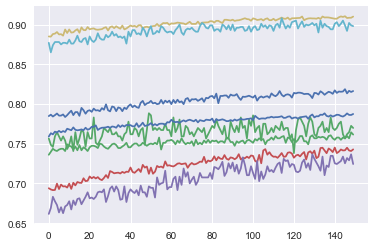

In [13]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier())
    test_simple_model_with_gradient(model, dataset, 1)

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))


CRDataset
Train precision 0.7930526935531351 0.7930526935531351 0.7930526935531351
Test precision 0.783068783068783 0.783068783068783 0.783068783068783


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))


MRDataset
Train precision 0.7229807191245441 0.7229807191245441 0.7229807191245441
Test precision 0.7197750702905342 0.7197750702905342 0.7197750702905342


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))


SUBJDataset
Train precision 0.8972222222222223 0.8972222222222223 0.8972222222222223
Test precision 0.895 0.895 0.895


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))


MPQADataset
Train precision 0.7865898376113148 0.7865898376113148 0.7865898376113148
Test precision 0.758718190386428 0.758718190386428 0.758718190386428


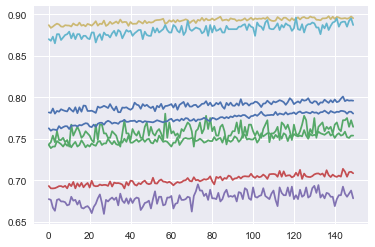

In [14]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier(), use_tfidf=True)
    test_simple_model_with_gradient(model, dataset, 1)

In [22]:
alpha = 0.01
dataset = datasets.CRDataset()
model = SimpleModel(classify.SkClassifier())
model.fit(dataset.train_samples(), dataset.train_labels())
_ = gradient_w(model, dataset, 150)


  1%|▏         | 2/150 [00:07<08:59,  3.65s/it, test_score=0.746, train_score=0.815]
Exception in thread Thread-28:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



KeyboardInterrupt: 

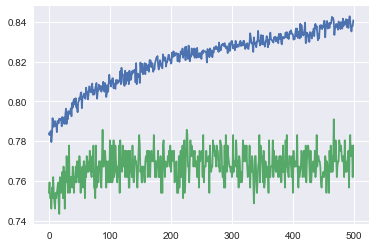

In [128]:
plt.plot(train_scores)
plt.plot(test_scores)